![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRQI3eK0GKmwgX-OdZHtW_Vd5pti7KZWJU7BORw_eM_l4fUQb8h9A)

# How to solve class imbalance
- 이 커널에선 우리가 종종 부정 거래 식별과 스팸 식별과 같은 문제에서 더 자주 발생하는 클래스 불균형 문제에 대해 논의할 것입니다.
- Loading Libraries
- Loading Data
- The metirc trap
- Data Preparating
- Resampling
- Resampling using sklearn
- Dimensionality Reduction and Clustering
- Python imblanced-learn module
- Algorithmic Ensemble Techniques

## Loading Require Libraries

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification

from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

import time
import matplotlib.patches as mpatches
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE

## Loding Data

In [2]:
%%time
train_transaction = pd.read_csv('../dataset/train_transaction.csv')
train_identity = pd.read_csv('../dataset/train_identity.csv')

print('Train dataset is loaded !')

Train dataset is loaded !
Wall time: 54.4 s


### Getting Basic Idea

In [3]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
train_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 1.7+ GB


In [5]:
train_identity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entries, 0 to 144232
Data columns (total 41 columns):
TransactionID    144233 non-null int64
id_01            144233 non-null float64
id_02            140872 non-null float64
id_03            66324 non-null float64
id_04            66324 non-null float64
id_05            136865 non-null float64
id_06            136865 non-null float64
id_07            5155 non-null float64
id_08            5155 non-null float64
id_09            74926 non-null float64
id_10            74926 non-null float64
id_11            140978 non-null float64
id_12            144233 non-null object
id_13            127320 non-null float64
id_14            80044 non-null float64
id_15            140985 non-null object
id_16            129340 non-null object
id_17            139369 non-null float64
id_18            45113 non-null float64
id_19            139318 non-null float64
id_20            139261 non-null float64
id_21            5159 non-null float64
id_2

### Target Variable

Text(0.5, 1.0, 'Target Variable Count')

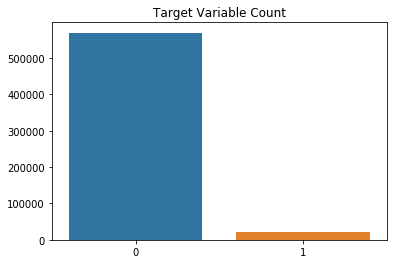

In [6]:
x = train_transaction['isFraud'].value_counts().values
sns.barplot([0,1],x)
plt.title('Target Variable Count')

- 이 데이터는 클래스 불균형 문제가 존재하는 것이 확연하게 드러납니다.
- 클래스 불균형 문제를 해결하는 것이 이 커널의 목적입니다.

## The metric trap
초보 분석가가 뷸균형 데이터세트를 처리할 때 발생하는 주요 문제 중 하나는 모델을 평가하는데 사용되는 지표와 관련이 있습니다. Accuracy와 같은 단순한 측정 기준을 사용하면 오해의 소지가 존재합니다. 클래스가 불균형한 데이터에서 가장 일반적인 클래스로 모두 예상한다면, 높은 Accuracy를 보일 것입니다. 그러나, 그것은 완전히 허황된 예측을 하는 것이나 다름없습니다.  

<b>False Positive</b>. 실제로는 발생하지 않았지만, 발생한다고 예측한 것.  
<b>False Negative</b>. 실제로 발생했지만, 발생하지 않았다고 예측한 것.  

<b> 성능 지표의 변경 </b>
정확도는 불균형 데이터를 평가할 때, 매우 오해의 소지가 있기 때문에 최선의 측정 지표가 아닙니다. 더 나은 통찰력을 제공할 수 있는 지표는 다음과 같습니다.

<b>Confusion Matrix</b>: 정확한 예측과 부정확한 예측 유형을 보여주는 표.  

<b>Precision</b>: 모든 긍정 값에서  옳은 긍정으로 예측한 값을 나눈 것. (True Positive / (True Positvie + False Positive))

<b>Recall</b> : 실제 긍정 값에서 옳은 긍정으로 예측한 값을 나눈 것. (True Positive / (True Positvie + False Negative))  

<b> F1 Score </b>: Precision과 Recall의 가중 평균

ROC, AUC 평가 지표는 각 클래스에 대해 관측 횟수가 비슷할 때 사용해야 합니다. Precision-Recall 곡선은 클래스간 큰 불균형이 존재할 때 사용해야 합니다.

## Merging Transaction and Idntity Dataset

In [7]:
train = train_transaction.merge(train_identity, how = 'left', left_index = True,
                               right_index = True)
y_train = train['isFraud'].astype('uint8')

print('Train Shape:', train.shape)

del train_transaction, train_identity

print('Dataset Merged!')

Train Shape: (590540, 435)
Dataset Merged!


### Reducing Memory Usage

In [8]:
%%time
# From kernel https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
# WARNING! THIS CAN DAMAGE THE DATA 
def reduce_mem_usage2(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

Wall time: 0 ns


In [9]:
train = reduce_mem_usage2(train)

Memory usage of dataframe is 1959.88 MB
Memory usage after optimization is: 527.82 MB
Decreased by 73.1%


### Splitting to Train and Validation

- 이제, 기존 훈련 데이터를 훈련 데이터와 검증 데이터로 나누겠습니다. 
- 검증 데이터의 비율은 20%입니다.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('isFraud', axis = 1),
                                                   y_train,test_size = .2, random_state = 42)

## Resampling
불균형 데이터를 처리하기 위해 보편적으로 채택된 기술을 Resampling이라고 합니다.  
- <b>UnderSampling</b>: 빈도 수가 더 많은 클래스에서 샘플을 제거해 균형을 맞추는 것
- <b>OverSampling</b>: 빈도 수가 더 적은 클래스에서 샘플을 반복하여 추가하는 것

![](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/resampling.png)

## Resampling Techniques using sklearn

### Oversample minority class

Oversampling은 소수 클래스를 복사하여 더 추가하는 것으로 정의할 수 있습니다. 분석할 데이터가 많지 않을 때 좋은 선택이 될 수 있습니다.  

Scikit-Learn의 Resampling Module을 사용하여 소수 클래스에서 무작위로 샘플을 복제할 것입니다.

In [11]:
X = pd.concat([X_train,y_train], axis =1)

not_fraud = X[X.isFraud == 0]
fraud = X[X.isFraud == 1]

# Upsampling
fraud_upsampled = resample(fraud,
                          replace = True,
                          n_samples = len(not_fraud),
                          random_state = 27)

# Combine majority and Upsampling Data
upsample = pd.concat([not_fraud,fraud_upsampled])

# Check class count
upsample.isFraud.value_counts()

1    456011
0    456011
Name: isFraud, dtype: int64

Text(0, 0.5, 'Count')

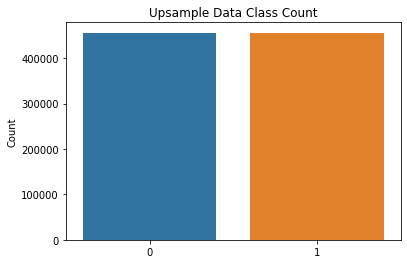

In [12]:
y = upsample.isFraud.value_counts()

sns.barplot(y=y,x=[0,1])
plt.title('Upsample Data Class Count')
plt.ylabel('Count')

### Undersample Majority Class
Undersampling은 다수의 클래스를 제거하는 것으로 정의할 수 있습니다. 분석할 데이터가 많을 때 좋은 선택이 될 수 있습니다. 하지만 가치있을 데이터를 제거할 수 있다는 단점이 존재합니다. 이 경우, 테스트 데이터에 대한 적합성이 떨어지고 일반화가 제대로 이루어지지 않을 수 있습니다.  

Scikit-Learn의 Resampling Module을 사용하여 다수의 클래스에서 무작위로 샘플을 제거할 것입니다.

In [13]:
not_fraud_downsample = resample(not_fraud,
                               replace = True,
                               n_samples = len(fraud),
                               random_state = 42)

# Combine minority and Downsampled majority
downsampled = pd.concat([not_fraud_downsample, fraud])

# Checking Count
downsampled.isFraud.value_counts()

1    16421
0    16421
Name: isFraud, dtype: int64

Text(0, 0.5, 'Count')

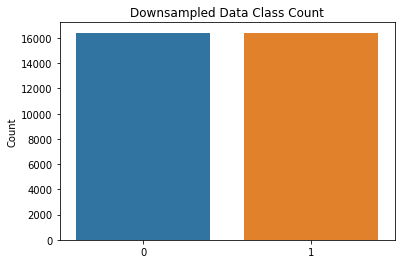

In [14]:
y = downsampled.isFraud.value_counts()

sns.barplot(y=y,x=[0,1])
plt.title('Downsampled Data Class Count')
plt.ylabel('Count')

이제 다른 Resampling Method를 확인해 보겠습니다. 

보다 쉽게 시각화할 수 있도록 make_classification 방법을 사용하여 크기가 작은 불균형 샘플 데이터를 생성해 보겠습니다.

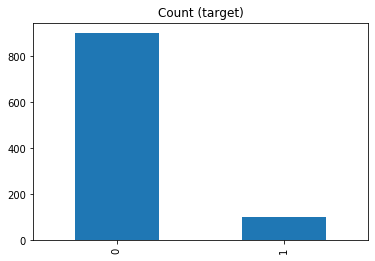

In [15]:
X,y = make_classification(n_classes = 2,
                         class_sep = 1.5,
                         weights = [0.9, 0.1],
                         n_informative = 3, n_redundant = 1, flip_y = 0,
                         n_features = 20, n_clusters_per_class = 1,
                         n_samples = 1000, random_state = 42)

df = pd.DataFrame(X)
df['target'] = y
df.target.value_counts().plot(kind='bar',title = 'Count (target)')

- 우선, 어떤 Resampling 방법을 사용하지 않고 분석을 수행하겠습니다. 
- Logistic Regression 모델을 이용해 데이터를 적합시키고 예측한 후, 결과값을 확인해 보겠습니다.

In [16]:
def logistic(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .2, random_state = 42)
    lr = LogisticRegression()
    lr.fit(X_train,y_train)
    prob = lr.predict_proba(X_test)
    return (prob[:,1], y_test)

In [17]:
probs,y_test = logistic(X,y)

Precision-Recall 곡선 및 ROC 곡선을 표시하는 두 가지 함수를 정의합니다.

In [18]:
def plot_pre_curve(y_test,probs):
    precision, recall, thresholds = precision_recall_curve(y_test, probs)
    plt.plot([0,1], [0.5, 0.5], linestyle = '--')
    plt.plot(recall, precision, marker = '.')
    plt.title('Precision - Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
    plt.show()
    
def plot_roc(y_test,prob):
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    plt.plot([0,1], [0,1], linestyle = '--')
    plt.plot(fpr,tpr, marker = '.')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positivie Rate')
    
    plt.show()

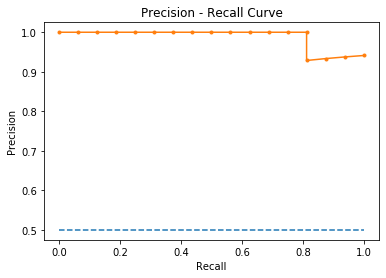

In [19]:
plot_pre_curve(y_test,probs)

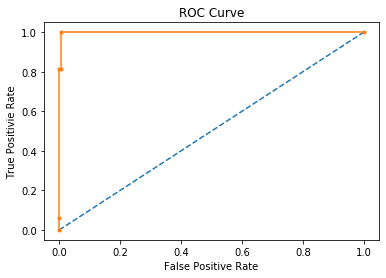

In [20]:
plot_roc(y_test,probs)

데이터 분포를 확인할 수 있도록 2차원 그래프 함수인 plot_2d_space를 생성합니다.

In [37]:
def plot_2d_space(X_train, y_train, X = X, y = y, label = 'Classes'):
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    
    fig,(ax1,ax2) = plt.subplots(1,2, figsize = (8,4))
    
    for l, c, m in zip(np.unique(y), colors, markers):
        ax1.scatter(X_train[y_train == l, 0],
                   X_train[y_train == l, 1],
                   c = c, label = l, marker = m)
    
    for l, c, m in zip(np.unique(y), colors, markers):
        ax2.scatter(X[y == l, 0],
                   X[y == l, 1],
                   c = c, label = l, marker = m)
    
    ax1.set_title(label)
    ax2.set_title('Original Data')
    plt.legend(loc = 'upper right')
    plt.show()

## Dimensionality Reduction and Clustering
t-SNE의 이해: 이 알고리즘을 이해하려면 다음 용어를 알고 있어야 합니다.

- Euclidean Distance (유클리드 거리)
- Conditional Probability (조건부 확률)
- Normal and T-Distribution Plots

아래 섹션에서는 세 가지 주요 차원 축소 알고리즘을 구현할 것입니다.

- t-SNE
- PCA
- Truncated SVD

In [23]:
# t-SNE 
t0 = time.time()
X_reduced_tsne = TSNE(n_components = 2, random_state = 42).fit_transform(X)
t1 = time.time()
print("t-SNE took {:.2f}s".format(t1-t0))

# PCA
t0 = time.time()
X_reduced_pca = PCA(n_components = 2, random_state = 42).fit_transform(X)
t1 = time.time()
print('PCA took {:.2f}s'.format(t1-t0))

# Truncated SVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components = 2, algorithm = 'randomized',random_state = 42).fit_transform(X)
t1 = time.time()
print('Truncated SVD took: {:.2f}s'.format(t1-t0))

t-SNE took 16.35s
PCA took 0.06s
Truncated SVD took: 0.01s


이제 2차원 공간에서 위의 세 가지 알고리즘을 시각화해보겠습니다.

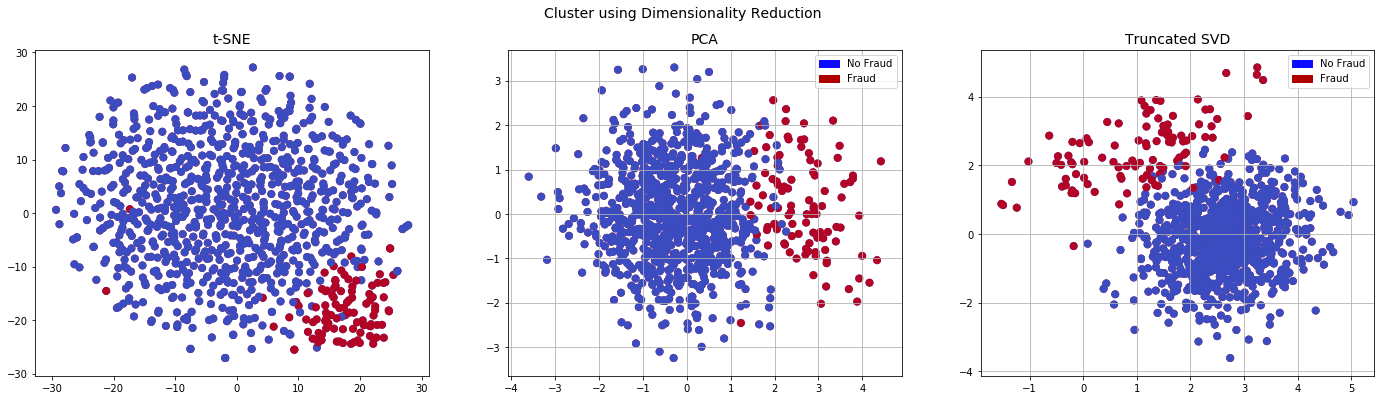

In [30]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (24,6))
f.suptitle('Cluster using Dimensionality Reduction', fontsize = 14)

blue_patch = mpatches.Patch(color = "#0A0AFF", label = 'No Fraud')
red_patch = mpatches.Patch(color = '#AF0000', label = 'Fraud')

# Creating t-SNE Scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c = (y==0), cmap = 'coolwarm', label = 'No Fraud', linewidths = 2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c = (y==1), cmap = 'coolwarm', label = 'Fraud', linewidths = 2)
ax1.set_title('t-SNE',fontsize = 14)

# Creating PCA Scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y==0),cmap = 'coolwarm', label = 'No Fraud', linewidths = 2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y==1),cmap = 'coolwarm', label = 'Fraud',linewidths = 2)
ax2.set_title('PCA', fontsize = 14)

ax2.grid(True)

ax2.legend(handles = [blue_patch, red_patch])

# Creating TruncatedSVD Scatter plot
ax3.scatter(X_reduced_svd[:,0],X_reduced_svd[:,1], c=(y==0),cmap = 'coolwarm', label = 'No Fraud', linewidth = 2)
ax3.scatter(X_reduced_svd[:,0],X_reduced_svd[:,1], c=(y==1), cmap = 'coolwarm', label = 'Fraud', linewidths = 2)
ax3.set_title('Truncated SVD', fontsize = 14)

ax3.grid(True)

ax3.legend(handles = [blue_patch, red_patch])

plt.show()

## Python imblanced - learn module

과학 문헌에 정교한 Resampling 기술이 더 많이 제안되었습니다.  

예를 들어, 다수의 클래스의 레코드들을 군집화할 수 있습니다. 그리고 각 군집에서 레코드를 제거하여 정보 보전을 도모하기 위해 Undersampling을 수행합니다.  
Over-Sampling에서는, 소수 클래스 레코드들의 복사본을 만드는 대신에 복사본에 작은 변화를 주어 더 다양한 합성표본을 만들 수 있습니다.  

Python library imbalanced-learn을 사용하여 이러한 Resampling 기법 중 몇가지를 적용해보겠습니다. 이것은 scikit-learn과 호환되며 scikit-learn-contrib 프로젝트의 일부입니다.

### Random Under-Sampling with imblanced-learn

The number of removed indices are 200


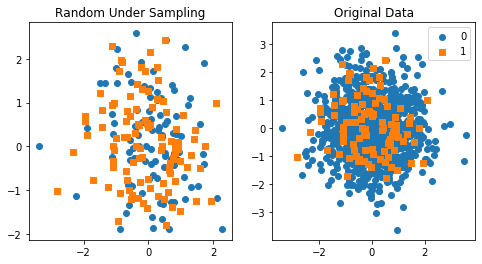

In [38]:
ran = RandomUnderSampler(return_indices = True)

X_rs,y_rs,dropped = ran.fit_sample(X,y)

print('The number of removed indices are', len(dropped))
plot_2d_space(X_rs,y_rs,X,y,'Random Under Sampling')

- 이제, 이 데이터를 적합시키고 예측한 후, 결과를 확인해 보겠습니다.

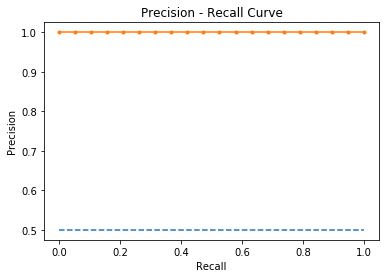

In [39]:
probs,y_test = logistic(X_rs,y_rs)
plot_pre_curve(y_test,probs)

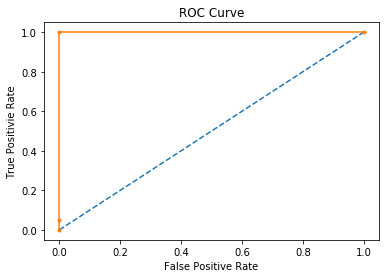

In [40]:
plot_roc(y_test,probs)

### Random Over-Sampling with imblanced-learn

The New Data Contains 1800 rows


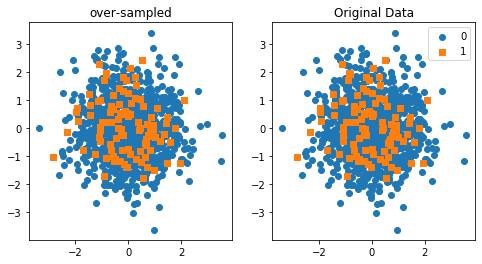

In [42]:
ran = RandomOverSampler()
X_ran, y_ran = ran.fit_resample(X,y)

print('The New Data Contains {} rows'.format(X_ran.shape[0]))

plot_2d_space(X_ran,y_ran,X,y,'over-sampled')

이제, 이 데이터를 적합시키고 예측한 후, 결과를 확인해 보겠습니다.

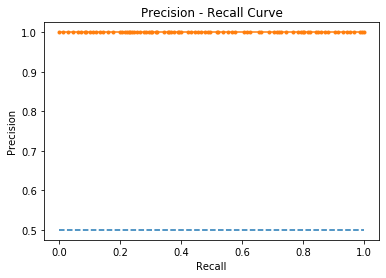

In [43]:
probs, y_test = logistic(X_ran,y_ran)
plot_pre_curve(y_test,probs)

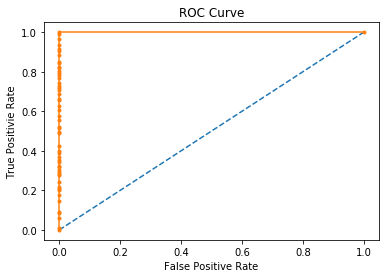

In [44]:
plot_roc(y_test,probs)

### Under-Sampling: Tomek links
Tomek links는 매우 가까운 인스턴스의 쌍이지만, 반대 클래스들 입니다. 각 쌍의 다수의 클래스 인스턴스를 제거하면 두 클래스 사이의 공간이 늘어나 분류 프로세스가 용이해집니다.  
![](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/tomek.png?v=2)

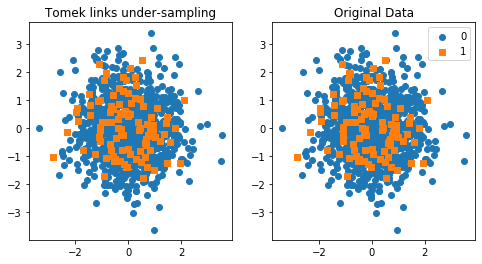

In [46]:
tl = TomekLinks(return_indices = True, ratio = 'majority')
X_tl, y_tl, id_tl = tl.fit_sample(X,y)

plot_2d_space(X_tl,y_tl,X,y,'Tomek links under-sampling')

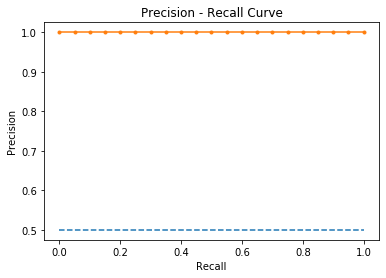

In [47]:
probs,y_test = logistic(X_tl,y_tl)
plot_pre_curve(y_test,probs)

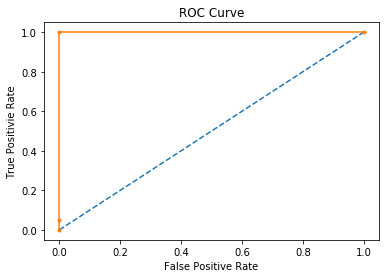

In [48]:
plot_roc(y_test,probs)

### Over-Sampling: SMOTE
이미 존재하는 요소들을 바탕으로 소수 클래스를 위한 새로운 요소들을 합성합니다. 소수 클래스에서 무작위로 한 점을 집어내 이 점에서 가장 가까운 이웃들을 계산합니다. 합성 포인트는 선택한 포인트와 그 주변 포인트 사이에 추가됩니다.  
![](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/smote.png)

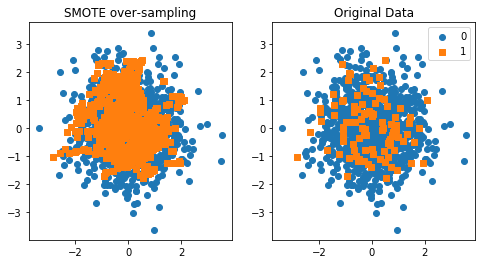

In [53]:
smote = SMOTE(ratio='minority')
X_sm,y_sm = smote.fit_sample(X,y)

plot_2d_space(X_sm,y_sm,X,y, 'SMOTE over-sampling')

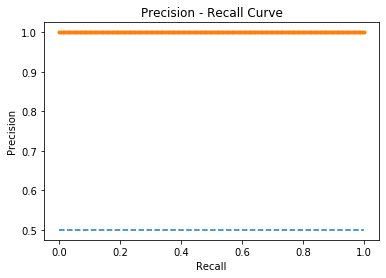

In [55]:
probs,y_test = logistic(X_sm,y_sm)
plot_pre_curve(y_test, probs)

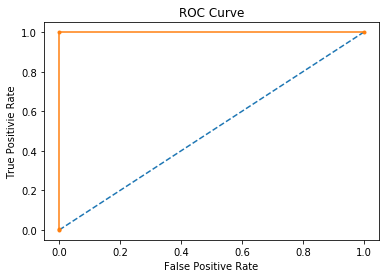

In [56]:
plot_roc(y_test,probs)

## Algorithmic Ensemble Techniques
위 섹션에서는 균형 잡힌 클래스를 제공하기 위해 원자료를 다시 샘플링하여 불균형한 데이터를 처리하는 방법을 알아봤습니다. 이번 섹션에서는 대체 접근법을 살펴보겠습니다.  

Ensemble Method의 주된 목적은 단일 분류기의 성능을 향상시키는 것에 있습니다. 이 접근 방식은 원래 데이터에서 2단계 분류기를 몇 개 구성한 다음 예측을하는 것입니다.

![](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/03/16142904/ICP4.png)

## XGBoost

![](https://miro.medium.com/max/1400/1*FLshv-wVDfu-i54OqvZdHg.png)

병렬 처리로 구현해 일반 Gradient Boosting보다 10배 가량 빠릅니다. 사용자가 최적화 목표와 평가 기준을 정의할 수 있고 누락된 값을 처리할 수 있는 내장 메커니즘을 가지고 있기 때문에, 매우 유연합니다. 

## Reference
- [Dealing with Imbalanced Data](https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18)
- [Tackling Class imbalance](https://www.kaggle.com/shahules/tackling-class-imbalance)
- [Resampling strategies for imbalanced datasets](https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets)